In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pandas as pd

%load_ext autoreload
%autoreload 2

Load the data for a particular mock (sample from the Latin Hypercube (LH)).

In [2]:
tag_params = '_p5_n10000'
idx_LH = 0

# change this directory path as needed
dir_mocks = f'/scratch/kstoreyf/muchisimocks/muchisimocks_lib{tag_params}'
subdir_prefix = 'LH'
fn_fields = f'{dir_mocks}/{subdir_prefix}{idx_LH}/bias_fields_eul_deconvolved_{idx_LH}.npy'
fn_fields_zspace = f'{dir_mocks}/{subdir_prefix}{idx_LH}/bias_fields_eul_zspace_deconvolved_{idx_LH}.npy'

bias_terms_eul = np.load(fn_fields)
bias_terms_eul_zspace = np.load(fn_fields_zspace)


Define plotting code

In [3]:
# copied from plotter.py (so that this notebook is self-contained)
def plot_field(tracer_field, normalize=False, vmin=None, vmax=None, 
                title=None, show_labels=True, show_colorbar=True,
                zslice_min=0, zslice_max=1, figsize=(6,6), log=False, symlog=False, 
                overdensity=True, label_cbar=None):

        if normalize:
            tracer_field /= np.max(np.abs(tracer_field))
        
        if vmax is None:
            vmax = 3*np.std(tracer_field)
       
        if tracer_field.ndim==3:
            field_2d = np.mean(tracer_field[:,:,zslice_min:zslice_max], axis=-1)
        elif tracer_field.ndim==2:
            field_2d = tracer_field
        else:
            raise ValueError("field must be 2d or 3d!")

        plt.figure(figsize=figsize, facecolor=(1,1,1,0))
        plt.title(title, fontsize=16)
        
        if symlog:
            from matplotlib.colors import SymLogNorm
            linthresh = 0.1*vmax
            linscale = 1.0
            if vmin is None:
                vmin = -vmax
            norm = SymLogNorm(
                    linthresh=linthresh, linscale=linscale,
                    vmin=vmin, vmax=vmax
                    )
        elif log:
            if vmin is None:
                vmin = np.min(tracer_field[tracer_field>0])
            norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
        else:
            if vmin is None:
                if overdensity:
                    vmin = -vmax
                else:
                    vmin = np.min(tracer_field[tracer_field>0])
            norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

        if overdensity:
            cmap = 'RdBu'
        else:
            cmap = 'Blues'
                
        im = plt.imshow(field_2d, norm=norm, cmap=cmap)
        ax = plt.gca()        
        
        if show_colorbar:
            if label_cbar is None:
                if overdensity:
                    label_cbar = r'overdensity $\delta$'
                else:
                    label_cbar = r'density'
            cbar = plt.colorbar(im, label=label_cbar, fraction=0.046, pad=0.04)
            cbar.ax.tick_params(labelsize=12) 
            
        if not show_labels:    
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)

        plt.show()

Plot the individual five bias fields

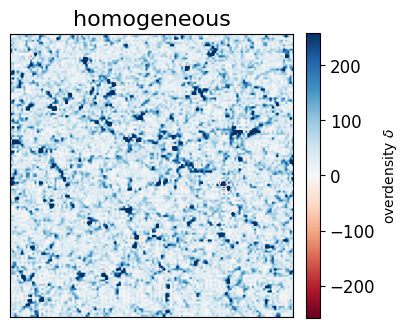

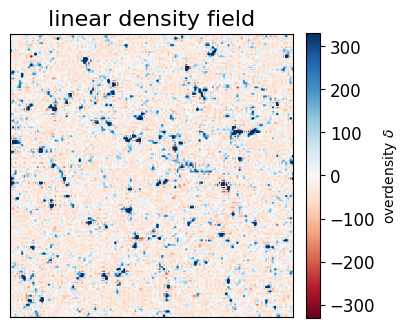

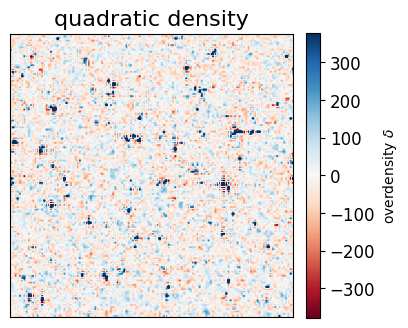

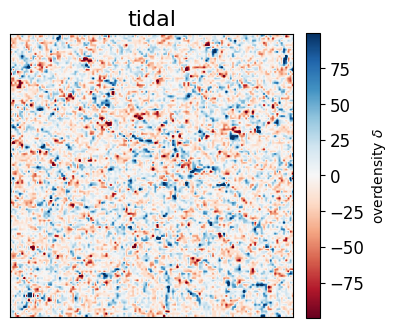

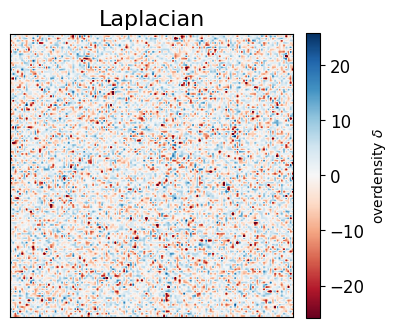

In [4]:
bias_field_labels = ['homogeneous', 'linear density field', 'quadratic density', 'tidal', 'Laplacian']
for i in range(len(bias_terms_eul)):
    plot_field(bias_terms_eul[i], figsize=(4,4), title=bias_field_labels[i],
                       show_labels=False)

Define code to combine the fields

In [5]:
# copied from utils.py (so that this notebook is self-contained)
def get_tracer_field(bias_fields_eul, bias_vector, n_grid_norm=None):
    assert len(bias_vector)==bias_fields_eul.shape[0]-1, "bias_vector must have length one less than number of bias fields"
    if n_grid_norm is None:
        n_grid_norm = bias_fields_eul.shape[-1]
        
    def _sum_bias_fields(fields, bias_vector):
        bias_vector_extended = np.concatenate(([1.0], bias_vector))
        return np.sum([fields[ii]*bias_vector_extended[ii] for ii in range(len(fields))], axis=0)
    
    tracer_field_eul = _sum_bias_fields(bias_fields_eul, bias_vector)
    tracer_field_eul_norm = tracer_field_eul/n_grid_norm**3
    
    return tracer_field_eul_norm

Choose some bias vector and combine the bias fields into a tracer field

In [6]:
#the order is b1, b2, bs2, blaplacian
bias_params = [1, 0.5, 0.5, 0.5]
# use 512 for normalization, because this is the original resolution of the mocks (they were downsampled to 128)
# this doesn't matter for visualization, but will when you go to compute statistics
n_grid_orig = 512
tracer_field_eul_norm = get_tracer_field(bias_terms_eul, bias_params, n_grid_norm=n_grid_orig)


Plot final tracer field

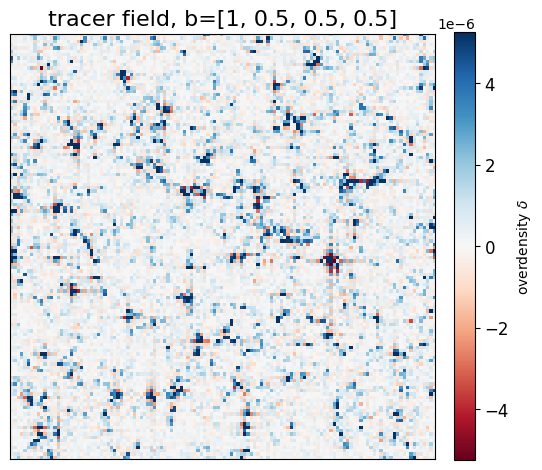

In [7]:
plot_field(tracer_field_eul_norm, figsize=(6,6), title=f'tracer field, b={bias_params}',
                   show_labels=False)

Now plot in redshift-space! 

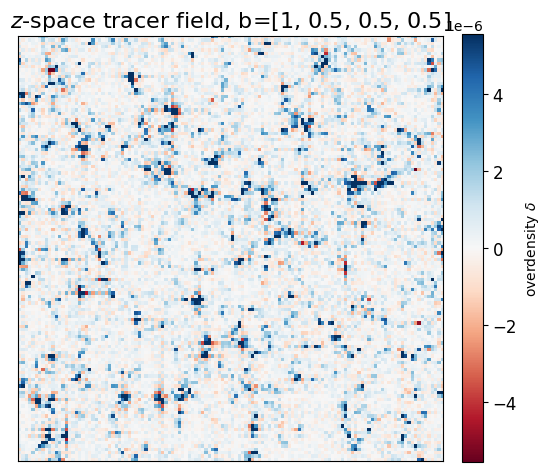

In [8]:
tracer_field_eul_norm_zspace = get_tracer_field(bias_terms_eul_zspace, bias_params, n_grid_norm=n_grid_orig)

plot_field(tracer_field_eul_norm_zspace, figsize=(6,6), title=rf'$z$-space tracer field, b={bias_params}',
                   show_labels=False)

Read in the cosmological parameters associated with this mock

In [9]:
# copied from data_loader.py (so that this notebook is self-contained)
def load_cosmo_params(tag_params, dir_params='../data/params'):
    fn_params = f'{dir_params}/params_lh{tag_params}.txt'
    fn_params_fixed = f'{dir_params}/params_fixed{tag_params}.txt'
    
    params_df = (
        pd.read_csv(fn_params, index_col=0)
        if os.path.exists(fn_params)
        else None
    )
    param_dict_fixed = (
        pd.read_csv(fn_params_fixed).iloc[0].to_dict() 
        if os.path.exists(fn_params_fixed)
        else {}
    )
    return params_df, param_dict_fixed

In [10]:
# the mock directory should contain these parameter files; or they might be in a central directory (default)
params_df, param_dict_fixed = load_cosmo_params(tag_params=tag_params, dir_params=dir_mocks)

In [11]:
print('fixed parameters:')
for key in param_dict_fixed.keys():
    print(f'{key}: {param_dict_fixed[key]:.3f}')

fixed parameters:
neutrino_mass: 0.000
w0: -1.000
wa: 0.000


In [12]:
print('parameters varied in LH:')
param_dict_vary = params_df.loc[idx_LH].to_dict()
for key in param_dict_vary.keys():
    print(f'{key}: {param_dict_vary[key]:.3f}')

parameters varied in LH:
omega_cold: 0.237
sigma8_cold: 0.698
hubble: 0.664
omega_baryon: 0.049
ns: 0.957
